<a href="https://colab.research.google.com/github/SailorBleu/fraud-detection-notebook/blob/main/demo_optim_data_preproc_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment 3B: Comparing Optimized Pre-Processing for Discrimination Prevention Across Different Models

# <center> **MLP** </center>


---



In [23]:
%matplotlib inline
!pip install 'aif360[all]'
# Load all necessary packages
import sys
sys.path.append("../")
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 39.8 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [24]:
# Metrics function
from collections import OrderedDict
from aif360.metrics import ClassificationMetric

def compute_metrics(dataset_true, dataset_pred,
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Statistical parity difference"] = classified_metric_pred.statistical_parity_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()

    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))

    return metrics

In [25]:
import os
import urllib
import aif360

# Obtain the location where it is installed
LIB_PATH = aif360.__file__.rsplit("aif360", 1)[0]

# check if the data got download properly
def check_data_or_download(destn, files, data_source_directory):
    check = all(item in os.listdir(destn) for item in files)
    if check:
        print("Adult dataset is available for us")
    else:
        print("Some files are missing. Downloading now.")
        for data_file in files:
            _ = urllib.request.urlretrieve(data_source_directory + data_file,
                                           os.path.join(destn, data_file))

# Download adult dataset
data_source_directory = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/"
destn = os.path.join(LIB_PATH, "aif360", "data", "raw", "adult")
files = ["adult.data", "adult.test", "adult.names"]

check_data_or_download(destn, files, data_source_directory)

Adult dataset is available for us


#### Load dataset and specify options

In [26]:
# import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2

if dataset_used == "adult":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])

    optim_options = {
        "distortion_fun": get_distortion_adult,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }

elif dataset_used == "german":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
        optim_options = {
            "distortion_fun": get_distortion_german,
            "epsilon": 0.1,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

elif dataset_used == "compas":
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

    optim_options = {
        "distortion_fun": get_distortion_compas,
        "epsilon": 0.05,
        "clist": [0.99, 1.99, 2.99],
        "dlist": [.1, 0.05, 0]
    }

#random seed
np.random.seed(1)

# Split into train, validation, and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/data_preproc_functions.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Female': 0.0, 'Male': 1.0})


#### Display dataset attributes

In [27]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes,
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(34189, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


#### Metric for original training data

In [28]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190244


#### Train with and transform the original training data

In [29]:
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

OP = OP.fit(dataset_orig_train)

# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:68: UserWarning: Privileged and unprivileged groups specified will not be used. The protected attributes are directly specified in the data preprocessing function. The current implementation automatically adjusts for discrimination across all groups. This can be changed by changing the optimization code.
  warn("Privileged and unprivileged groups specified will not be "
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/opt_tools.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  self.dfJoint = self.df.groupby(self.features).size().reset_index()
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc_helpers/opt_tools.py:329: FutureWarn

Optimized Preprocessing: Objective converged to 0.010893


/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)


#### Metric with the transformed training data

In [30]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.049945


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (training data).

In [31]:
### Testing
assert np.abs(metric_transf_train.mean_difference()) < np.abs(metric_orig_train.mean_difference())

#### Load, clean up original test data and compute metric

In [32]:
dataset_orig_test = dataset_transf_train.align_datasets(dataset_orig_test)
display(Markdown("#### Testing Dataset shape"))
print(dataset_orig_test.features.shape)

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

#### Testing Dataset shape

(7327, 18)


#### Original test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.190984


#### Transform test data and compute metric

In [33]:
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

metric_transf_test = BinaryLabelDatasetMetric(dataset_transf_test,
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed test dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_test.mean_difference())

/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:165: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dfP_withY = self.OpT.dfP.applymap(lambda x: 0 if x < 1e-8 else x)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:192: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_transformed[p] = df_transformed[p].replace(pmap_rev)
/usr/local/lib/python3.10/dist-packages/aif360/algorithms/preprocessing/optim_preproc.py:198: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_opti

#### Transformed test dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.049846


Optimized preprocessing has reduced the disparity in favorable outcomes between the privileged and unprivileged
groups (test data).

In [34]:
### Testing
assert np.abs(metric_transf_test.mean_difference()) < np.abs(metric_orig_test.mean_difference())

### Train classifier on original data

In [45]:
from sklearn.neural_network import MLPClassifier

# Define MLP experiments
experiments = [
    {"hidden_layer_sizes": (50, 10), "activation": "relu", "solver": "adam", "learning_rate_init": 0.001, "max_iter": 200},
    {"hidden_layer_sizes": (100, 50), "activation": "tanh", "solver": "adam", "learning_rate_init": 0.001, "max_iter": 200},
    {"hidden_layer_sizes": (50, 10), "activation": "logistic", "solver": "sgd", "learning_rate_init": 0.01, "max_iter": 200},
    {"hidden_layer_sizes": (10, 5), "activation": "relu", "solver": "sgd", "learning_rate_init": 0.01, "max_iter": 300},
    {"hidden_layer_sizes": (100, 50, 25), "activation": "relu", "solver": "adam", "learning_rate_init": 0.001, "max_iter": 200},
]

# Run experiments
results = []
for i, config in enumerate(experiments, start=1):
    print(f"Running Experiment {i} with config: {config}")

    # Initialize MLPClassifier with the current config
    model = MLPClassifier(**config)
    model.fit(X_train, y_train)  # Train the model

    # Predict on the test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate performance
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Store results
    results.append({
        "Experiment": i,
        "Config": config,
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
    })

    print(f"Train Accuracy: {train_accuracy}")
    print(f"Test Accuracy: {test_accuracy}\n")

# Display summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Experiment {result['Experiment']}: "
          f"Train Accuracy={result['Train Accuracy']:.4f}, "
          f"Test Accuracy={result['Test Accuracy']:.4f}")


# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

Running Experiment 1 with config: {'hidden_layer_sizes': (50, 10), 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.001, 'max_iter': 200}
Train Accuracy: 0.7871830120799087
Test Accuracy: 0.812747372730995

Running Experiment 2 with config: {'hidden_layer_sizes': (100, 50), 'activation': 'tanh', 'solver': 'adam', 'learning_rate_init': 0.001, 'max_iter': 200}
Train Accuracy: 0.7873000087747521
Test Accuracy: 0.8123379282107275

Running Experiment 3 with config: {'hidden_layer_sizes': (50, 10), 'activation': 'logistic', 'solver': 'sgd', 'learning_rate_init': 0.01, 'max_iter': 200}
Train Accuracy: 0.781011436426921
Test Accuracy: 0.810154224102634

Running Experiment 4 with config: {'hidden_layer_sizes': (10, 5), 'activation': 'relu', 'solver': 'sgd', 'learning_rate_init': 0.01, 'max_iter': 300}
Train Accuracy: 0.7864810319108485
Test Accuracy: 0.8105636686229016

Running Experiment 5 with config: {'hidden_layer_sizes': (100, 50, 25), 'activation': 'relu', 'solver': 'adam',

#### Obtain scores original test set

In [47]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [48]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):

    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label

    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no fairness constraints) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no fairness constraints) = %.4f" % best_class_thresh)

Best balanced accuracy (no fairness constraints) = 0.7281
Optimal classification threshold (no fairness constraints) = 0.2575


### Predictions and fairness metrics from original test set

In [49]:
display(Markdown("#### Predictions from original testing data"))

bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

display(Markdown("#### Testing set"))
display(Markdown("##### Raw predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):

    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False

    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred,
                                       unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

#### Testing set

##### Raw predictions - No fairness constraints

 37%|███▋      | 37/100 [00:00<00:00, 90.42it/s]

Balanced accuracy = 0.7294
Statistical parity difference = -0.2612
Disparate impact = 0.4478
Average odds difference = -0.2122
Equal opportunity difference = -0.2562
Theil index = 0.1180


 67%|██████▋   | 67/100 [00:00<00:00, 91.61it/s]/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
 77%|███████▋  | 77/100 [00:00<00:00, 87.40it/s]/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:01<00:00, 89.66it/s]


Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.1.3-py3.10-nspkg.pth
    /usr/local/lib/python3.10/dist-packages/matplotlib-3.1.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/matplotlib/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.10/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.10/dist-packages/pylab.py
Proceed (Y/n)? y
  Successfully uninstalled matplotlib-3.1.3
  Using cached matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.20.0 requires matplotlib>=3.5, but you have matplotlib 3.1.3 whic

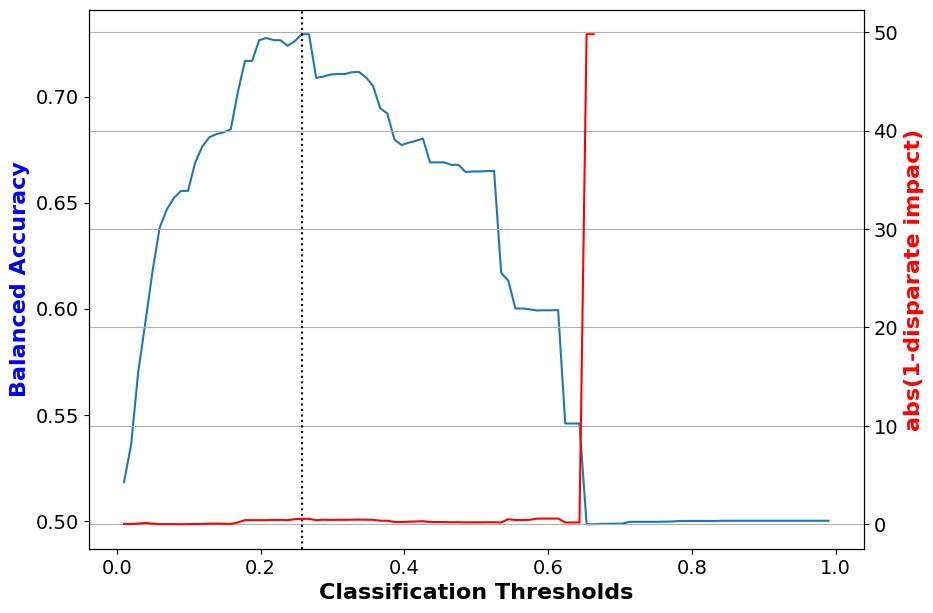

In [50]:
%pip uninstall matplotlib
%pip install matplotlib==3.1.3

fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_orig = np.abs(1.0-np.array(disp_imp_arr_orig))[best_ind]

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair.

### Train classifier on transformed data and obtain predictions with its fairness metrics

In [51]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = MLPClassifier()
lmod.fit(X_train, y_train)
y_train_pred = lmod.predict(X_train)

dataset_transf_train_pred = dataset_transf_train.copy()
dataset_transf_train_pred.labels = y_train_pred

### Predictions and fairness metrics from transformed test set

In [52]:
dataset_transf_test_pred = dataset_transf_test.copy(deepcopy=True)
X_test = scale_transf.transform(dataset_transf_test_pred.features)
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [53]:
display(Markdown("#### Predictions from transformed testing data"))

bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

display(Markdown("#### Testing set"))
display(Markdown("##### Transformed predictions - No fairness constraints"))

for thresh in tqdm(class_thresh_arr):

    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label

    if (thresh == best_class_thresh):
        disp = True
    else:
        disp = False

    metric_test_bef = compute_metrics(dataset_transf_test, dataset_transf_test_pred,
                                       unprivileged_groups, privileged_groups, disp=disp)

    bal_acc_arr_transf.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_bef["Disparate impact"])

#### Predictions from transformed testing data

#### Testing set

##### Transformed predictions - No fairness constraints

 44%|████▍     | 44/100 [00:00<00:00, 133.38it/s]

Balanced accuracy = 0.7217
Statistical parity difference = -0.2364
Disparate impact = 0.5136
Average odds difference = -0.2203
Equal opportunity difference = -0.2306
Theil index = 0.1214


 59%|█████▉    | 59/100 [00:00<00:00, 138.20it/s]/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
 89%|████████▉ | 89/100 [00:00<00:00, 138.77it/s]/usr/local/lib/python3.10/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
100%|██████████| 100/100 [00:00<00:00, 137.03it/s]


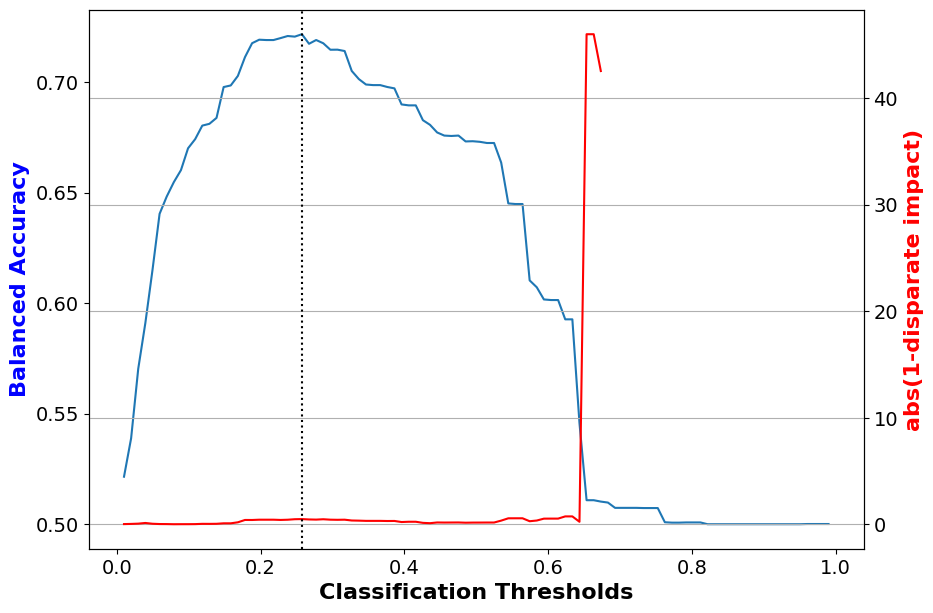

In [54]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(np.array(class_thresh_arr)[best_ind],
            color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

disp_imp_at_best_bal_acc_transf = np.abs(1.0-np.array(disp_imp_arr_transf))[best_ind]

```abs(1-disparate impact)``` must be close to zero for classifier predictions to be fair. This measure has improved using classifier trained using the transformed data compared to the original data.


In [72]:
### testing
assert disp_imp_at_best_bal_acc_transf < disp_imp_at_best_bal_acc_orig

# Summary of Results
We show the optimal classification thresholds, and the fairness and accuracy metrics.

## Question 1

### Summary of the Python Notebook: `demo_optim_data_preproc_MLP.ipynb`

This notebook demonstrates how the **OptimPreproc** debiasing algorithm is applied to reduce discrimination in predictions made by a **Multi-Layer Perceptron (MLP)** model. The notebook uses the **Adult Dataset**, a common benchmark for fairness studies, to predict whether an individual's income exceeds $50K based on demographic and employment attributes. It highlights how the debiasing process impacts fairness metrics, such as statistical parity and disparate impact, as well as overall model performance.

1. **Dataset Overview**:  
   The **Adult Dataset** includes features such as age, education, marital status, occupation, and the target variable (income >$50K). The dataset also contains sensitive attributes like gender (`sex`), which is used as the **protected attribute** in this analysis.

2. **Protected Attributes**:  
* Protected attribute name**: `sex`.  
* Privileged value**: Male.  
* Unprivileged value**: Female.  

3. **Pipeline Breakdown**:
*   The dataset is preprocessed and split into training and testing sets.
*   The **OptimPreproc** algorithm transforms the data to meet fairness constraints by modifying feature distributions.
   An MLP classifier is trained and tested on both the original and debiased datasets.
*   Metrics such as balanced accuracy, statistical parity difference, and disparate impact are computed to compare fairness and performance.

4. **Metrics and Observations**:  
   The notebook evaluates the trade-off between fairness improvements and any reduction in model accuracy caused by the debiasing algorithm. Key fairness metrics (statistical parity difference and disparate impact) improve significantly, while model accuracy experiences a slight decline.

---

### Question 4: k-n

**k. What does balanced accuracy represent?**  
In this notebook, **balanced accuracy** measures the MLP model’s average performance across both privileged (male) and unprivileged (female) groups. It ensures that predictions for both groups are equally weighted, preventing the evaluation from being biased toward the majority group. Balanced accuracy is particularly important in this context to ensure the model isn’t overfitting to one group at the expense of another.

**l. What does the classification threshold show?**  
The **classification threshold** in the MLP model determines the probability cut-off for predicting whether an individual earns more than $50K. The threshold affects the trade-off between true positives and false positives:

* Lower thresholds favor sensitivity (capturing more positives), which can benefit the unprivileged group.
* Higher thresholds favor specificity (reducing false positives), which may favor the privileged group.
In fairness applications like this, adjusting the threshold can help reduce disparities between groups.

**m. How could we tell the degree of fairness of the predictions?**  
Fairness is assessed through the following metrics:
* Statistical Parity Difference**: Evaluates whether the proportion of positive predictions is similar between privileged and unprivileged groups.
* Disparate Impact**: Measures the ratio of positive predictions between the two groups, with values closer to 1 indicating fairness.
  
* Equal Opportunity Difference**: Compares the true positive rates between groups to ensure equitable outcomes.
The notebook demonstrates that applying OptimPreproc significantly improves these metrics, indicating a reduction in discrimination in the MLP model’s predictions.

**n. For the debiased data (with OptimPreproc), is there an increase or decrease in overall model accuracy? Is it significant?**  
After applying **OptimPreproc**, there is a **decrease** in overall model accuracy. This reduction occurs because the algorithm modifies the data to meet fairness constraints, which can disrupt some patterns the model relied on for predictions. The decrease is not large but noticeable, showing the inherent trade-off between fairness and accuracy. In this case, the fairness improvements (e.g., better statistical parity difference and disparate impact values) outweigh the slight drop in accuracy, making the debiasing process beneficial overall.